In [1]:
import numpy as np
import h5py
import keras

from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Activation, Dense, concatenate, Input
from keras.models import Model

/anaconda/envs/DeepLearning/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load Synet Labels
labels = np.loadtxt("model_data/synset_words.txt" , str, delimiter='\t')

for i in range(len(labels)):
    tmp_label = labels[i].split(',')[0].split(' ',1)[1]
    labels[i] = tmp_label

print(labels[0]) #outputs: tench

tench


In [3]:
def fire_block(x, block_id="2", s_filters=3, e_filters=4):    
    squeeze = Conv2D(filters=s_filters, kernel_size=1, padding="valid", name="fire{}_s1x1_{}".format(block_id, s_filters))(x)
    squeeze = Activation("relu", name="fire{}_relu_s_1".format(block_id))(squeeze)
    
    expand_1x1 = Conv2D(filters=e_filters, kernel_size=1, padding="valid", name="fire{}_e1x1_{}".format(block_id, e_filters))(squeeze)
    expand_1x1 = Activation("relu", name="fire{}_relu_e_1".format(block_id))(expand_1x1)
    
    expand_3x3 = Conv2D(filters=e_filters, kernel_size=3, padding="same", name="fire{}_e3x3_{}".format(block_id, e_filters))(squeeze)
    expand_3x3 = Activation("relu", name="fire{}_relu_e_3".format(block_id))(expand_3x3)
        
    return concatenate( [expand_1x1, expand_3x3], axis=3, name="fire{}_conc".format(block_id))

In [4]:
def squeezenet_body( inputs):
    x = Conv2D(filters=96, kernel_size=7, strides=2, name="conv_1")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=3, strides=2, name="maxpool_1")(x)
    
    x = fire_block(x, "2", 16, 64)
    x = fire_block(x, "3", 16, 64)
    x = fire_block(x, "4", 32, 128)
    
    x = MaxPooling2D(pool_size=3, strides=2, name="maxpool_4")(x)

    x = fire_block(x, "5", 32, 128)
    x = fire_block(x, "6", 48, 192)
    x = fire_block(x, "7", 48, 192)
    x = fire_block(x, "8", 64, 256)

    x = MaxPooling2D(pool_size=3, strides=2, name="maxpool_8")(x)
        
    x = fire_block(x, "9", 64, 256)
    
    x = Dropout(0.5)(x)
        
    x = Conv2D(filters=1000, kernel_size=1, strides=1, name="conv_10")(x)
    x = Activation("relu")(x)
    x = AveragePooling2D(pool_size=13, strides=1, name="avgpool_10")(x)
    
    return x
        

def squeezenet( inputs):
    body  = squeezenet_body(inputs) 
    logits = Activation("softmax", name="output")(body)
    return Model(inputs, logits)


model = squeezenet( Input(shape=(227,227,3)))

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 111, 111, 96) 14208       input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 96) 0           conv_1[0][0]                     
__________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)        (None, 55, 55, 96)   0           activation_1[0][0]               
__________________________________________________________________________________________________
fire2_s1x1

## (OPTIONAL) Convert SqueezeNet V1.0 original caffe weights to h5 format.

```python
from contrib.caffe_weight_converter import convert_caffemodel_to_keras

convert_caffemodel_to_keras('model_data/squeezenet_v1_0.h5',
                            'SqueezeNet_v1.0/deploy.prototxt',
                            'SqueezeNet_v1.0/squeezenet_v1.0.caffemodel')
```

In [6]:
def load_fire_block_weights( model, layer_num, fire_block, h5_weights=None):
    fire_block
    
    W = np.array( h5_weights[fire_block]['squeeze1x1'][fire_block]['squeeze1x1']['kernel:0'])
    b = np.array( h5_weights[fire_block]['squeeze1x1'][fire_block]['squeeze1x1']['bias:0'])    
    model.layers[layer_num].set_weights([W,b])

    W = np.array( h5_weights[fire_block]['expand1x1'][fire_block]['expand1x1']['kernel:0'])
    b = np.array( h5_weights[fire_block]['expand1x1'][fire_block]['expand1x1']['bias:0'])    
    model.layers[layer_num+2].set_weights([W,b])

    W = np.array( h5_weights[fire_block]['expand3x3'][fire_block]['expand3x3']['kernel:0'])
    b = np.array( h5_weights[fire_block]['expand3x3'][fire_block]['expand3x3']['bias:0'])    
    model.layers[layer_num+3].set_weights([W,b])    


with h5py.File("model_data/squeezenet_v1_0.h5", 'r') as f: 
    W = np.array(f['conv1']['conv1']['kernel:0'])
    b = np.array(f['conv1']['conv1']['bias:0'])
    model.layers[1].set_weights([W,b])

    load_fire_block_weights( model, 4,  "fire2", f )
    load_fire_block_weights( model, 11, "fire3", f )
    load_fire_block_weights( model, 18, "fire4", f )

    load_fire_block_weights( model, 26, "fire5", f )
    load_fire_block_weights( model, 33, "fire6", f )
    load_fire_block_weights( model, 40, "fire7", f )
    load_fire_block_weights( model, 47, "fire8", f )
    
    load_fire_block_weights( model, 55, "fire9", f )
    
    W = np.array(f['conv10']['conv10']['kernel:0'])
    b = np.array(f['conv10']['conv10']['bias:0'])
    model.layers[63].set_weights([W,b])
    
print("Weights loaded!")

Weights loaded!


In [7]:
# Save model (OPTIONAL)
# model.save("model_data/squeezenet_model_v1_0.h5")

In [10]:
# Make predictions

import scipy
import matplotlib.pyplot as plt

def load_image_as_array( image_path, resize=None, crop=None):
    image = np.array(scipy.misc.imread(image_path, flatten = False))

    if resize is not None:
        image = scipy.misc.imresize(image, size = resize)

    if crop is not None:
        hstart = (image.shape[0] - crop[0]) // 2
        hend   = hstart + crop[0]
        wstart = (image.shape[1] - crop[1]) // 2
        wend   = wstart + crop[1]
        
        image = image[ hstart:hend, wstart:wend,:]
    
    return image


def predict_image( sample):
    gt_label, gt_label_id, filename =  sample
    
    im = load_image_as_array( filename, resize=(227,227))

    plt.imshow(im)
    plt.show()

    x = im.reshape((1,) + im.shape)
    predictions = model.predict(x, verbose=1)[0,0,0,:]
    idxs = np.flip( np.argsort(predictions), axis=0)

    print("* Ground-Truth: {} - {}".format(gt_label, gt_label_id))

    print("* Top-1 Prediction: {} - {} - {:.3f}%".format(labels[ idxs[0]], idxs[0], predictions[idxs[0]]))

    print("* Top-5 Predictions:")
    for i in range(5):
        print("  {}. {} - {} - {:.3f}%".format(i+1, labels[ idxs[i]], idxs[i], predictions[idxs[0]]))

/anaconda/envs/DeepLearning/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/anaconda/envs/DeepLearning/lib/python3.5/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


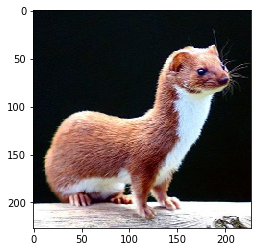

1/1 [==============================] - 0s 34ms/step
* Ground-Truth: weasel - 356
* Top-1 Prediction: mongoose - 298 - 0.579%
* Top-5 Predictions:
  1. mongoose - 298 - 0.579%
  2. mink - 357 - 0.579%
  3. weasel - 356 - 0.579%
  4. hen - 8 - 0.579%
  5. Chihuahua - 151 - 0.579%


In [11]:
SAMPLES = [ 
    ("weasel", 356, "examples/weasel.jpg"),
    ("pembroke_corgi", 263, "examples/pembroke_corgi.jpg"),    
    ("foal", 263, "examples/foal.jpg"),      
    ("poodle", 265, "examples/poodle.jpg"), 
    ("quail", 85, "examples/quail.jpg"),     
    ("crane", 517, "examples/crane.jpg"),     
    ("crane", 517, "examples/crane2.jpg"),     
    ("crane", 517, "examples/crane3.jpg"),     
    ("crane", 517, "examples/crane4.jpg"),     
]

predict_image( SAMPLES[0])